We investigate the velocity distribution, considering the relation of the floe velocities to the Normal distribution. Initially, we examine the velocity distribution using the full set of measurements, then examine the effects of local sea ice concentration, distance to the sea ice edge, floe size, and time of year. Again an issue appears where Proplot is unable to produce a figure, I'm not sure where the error appears but I may need to try a different system in the future

In [11]:
import itertools
import numpy as np
import pandas as pd
import proplot as pplt
import os
import sys
import warnings

sys.path.append('../scripts/')
from drifter import compute_along_across_components
from scipy.interpolate import interp2d
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

df_ift = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv', index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
df_ift.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'u_along',
       'v_along', 'u_across', 'v_across', 'U_fluctuating', 'U_along',
       'u_along_15D', 'v_along_15D', 'u_across_15D', 'v_across_15D',
       'U_fluctuating_15D', 'U_along_15D', 'u_along_31D', 'v_along_31D',
       'u_across_31D', 'v_across_31D', 'U_fluctuating_31D', 'U_along_31D'],
      dtype='object')

In [7]:
# Additional filter
speed = df_ift['speed'].copy()
print('Anomalous speed n =', len(speed[speed > 1.5]))
mean_u = df_ift.loc[:, 'u'].mean()
mean_v = df_ift.loc[:, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]
print('Flagged: ', df_ift.qc_flag.sum())

Anomalous speed n = 0
Flagged:  0.0


In [8]:
sim_ualong = pd.read_csv('../data/simulation/u_along.csv', index_col=0)
sim_uacross = pd.read_csv('../data/simulation/u_across.csv', index_col=0)
sim_std_dev = pd.read_csv('../data/simulation/stdev.csv', index_col=0)

The data are flagged based on travel distance (minimum 1 pixel), circularity (minimum 0.6), and speed (max speed, and the minimum of the daily speeds). Probably too many floes are flagged, but we have to start somewhere. I've calculated the 5-day, 15-day, and 31-day local averages using the NSIDC data. We use these fields as an estimate of the direction of the mean current. We examine 

In [9]:
def plot_velocity_distribution(data_df, savename='../figures/velocity_histogram.png',
                             vel_comp1='U_along', vel_comp2='U_fluctuating',
                             vc1_name='Longitudinal', vc2_name='Transverse'):
    """Plots the histograms of the specified velocity components (normalized by standard deviation)
    against a Gaussian distribution. All floes in data_df lumped together. Future update could provide some
    sort of weighting."""

    all_u = data_df[vel_comp1].dropna()
    all_v = data_df[vel_comp2].dropna()
    print(len(all_u))
    fig, axs = pplt.subplots(ncols=2, width=6, sharex=False)
    normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
    for ax, data in zip(axs, [all_u, all_v]):
        pdf, x_bins = np.histogram(data/np.std(data), bins=np.linspace(-7, 7, 151), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        print(np.std(data))
        ax.plot(x_center, pdf, marker='.', lw=0, color='b') 
        ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label='N(0, 1)')
    axs[0].format(title=vc1_name, xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
    axs[1].format(title=vc2_name, xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
    axs[0].legend(loc='ul', ncols=1)
    axs[1].legend(loc='ul', ncols=1)
    axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
               yformatter='log', suptitle='', fontsize=12, abc=True)
    if savename is not None:
        fig.save(savename, dpi=300)


In [13]:
df_ift.columns

Index(['datetime', 'floe_id', 'longitude', 'latitude', 'x_stere', 'y_stere',
       'area', 'perimeter', 'axis_major_length', 'axis_minor_length',
       'solidity', 'circularity', 'nsidc_sic', 'lr_probability', 'zeta',
       'zeta_est', 'u', 'v', 'bearing', 'speed', 'area_km2', 'perimeter_km',
       'axis_major_length_km', 'axis_minor_length_km', 'edge_dist_km',
       'coast_dist_km', 'u_nsidc', 'v_nsidc', 'u5D_nsidc', 'v5D_nsidc',
       'u15D_nsidc', 'v15D_nsidc', 'u31D_nsidc', 'v31D_nsidc', 'u_along',
       'v_along', 'u_across', 'v_across', 'U_fluctuating', 'U_along',
       'u_along_15D', 'v_along_15D', 'u_across_15D', 'v_across_15D',
       'U_fluctuating_15D', 'U_along_15D', 'u_along_31D', 'v_along_31D',
       'u_across_31D', 'v_across_31D', 'U_fluctuating_31D', 'U_along_31D'],
      dtype='object')

In [49]:
results = {}
for tau in ['5D', '15D', '31D']:
    tau_alt = ''
    if tau != '5D':
        tau_alt = '_' + tau
    data = pd.DataFrame({'datetime': df_ift['datetime'],
                         'floe_id': df_ift['floe_id'],
                         'u': df_ift['u'], 
                         'v': df_ift['v'],
                         'u_mean': df_ift['u' + tau + '_nsidc'],
                         'v_mean': df_ift['v' + tau + '_nsidc'],
                         'u_along': df_ift['u_along' + tau_alt],
                         'v_along': df_ift['v_along' + tau_alt],
                         'U_fluctuating': df_ift['U_fluctuating' + tau_alt],
                         'U_along': df_ift['U_along' + tau_alt]
                         }).dropna()
    # data = data.loc[data.qc_flag==0].copy()
    # data = compute_along_across_components(data)
    results[tau] = data.copy()

results_anomalies = {}
for tau in ['5D', '15D', '31D']:
    data = pd.DataFrame({'datetime': df_ift['datetime'],
                         'floe_id': df_ift['floe_id'],
                         'edge_dist': df_ift['edge_dist_km'],
                         'coast_dist': df_ift['coast_dist_km'],
                         'floe_size': df_ift['area_km2'],
                         'rotation_rate': df_ift['zeta'],
                         'sea_ice_concentration': df_ift['nsidc_sic'],
                         'u': df_ift['u'] - df_ift['u_nsidc'], 
                         'v': df_ift['v'] - df_ift['v_nsidc'],
                         'u_mean': df_ift['u' + tau + '_nsidc'],
                         'v_mean': df_ift['v' + tau + '_nsidc']
                         }).dropna()
    data = compute_along_across_components(data)
    results_anomalies[tau] = data.copy()

Some things to think about
1. Should we expect that the along-track component is symmetric around 0? If the climatological direction is correct, I think we should expect assymetry in the magnitude. The anomalies in the along track and cross track directions may be different in interesting ways. If the NSIDC product is biased low, then we expect a distribution where there are more positive anomalies than negative anomalies.

5D U_along 12.734 cm/s
15D U_along 12.712 cm/s
31D U_along 12.725 cm/s
5D U_fluctuating 6.314 cm/s
15D U_fluctuating 6.447 cm/s
31D U_fluctuating 6.324 cm/s


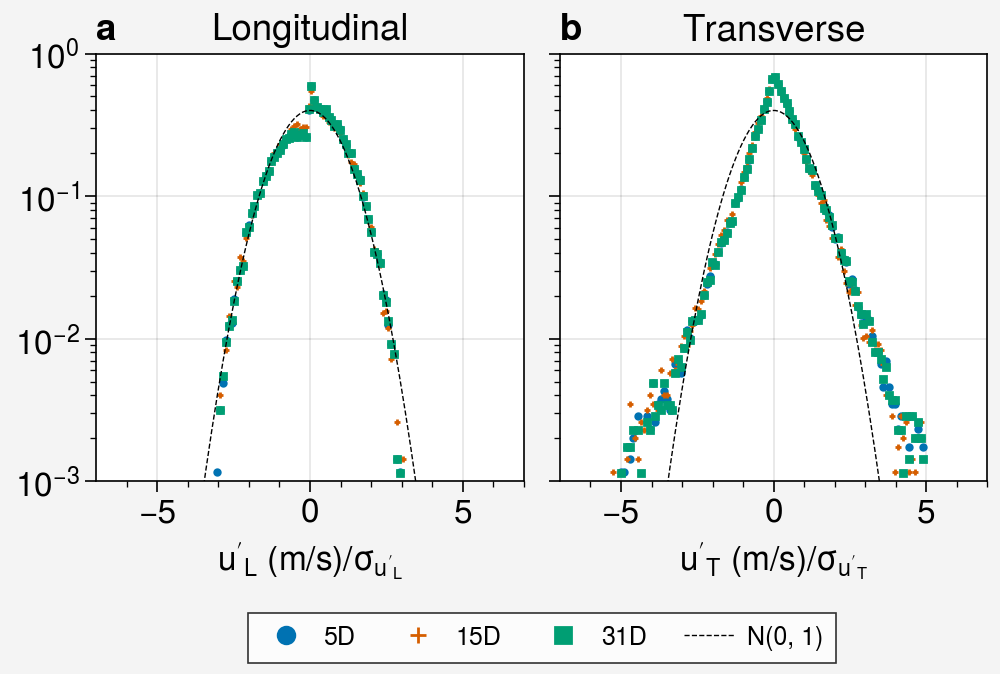

In [44]:
fig, axs = pplt.subplots(ncols=2, width="5in", sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, var in zip(axs, ['U_along', 'U_fluctuating']):
    for tau, m in zip(results, ['o', '+', 's']):
        u = results[tau][var]
        ustd = results[tau][var].std()
        print(tau, var, np.round(ustd*100, 3), 'cm/s')   
        pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        if 'along' in var:
            label = tau
            label_pdf = 'N(0, 1)'
        else:
            label = ''
            label_pdf = ''
        ax.plot(x_center, pdf, marker=m, lw=0, label=label, ms=2) 
     
    ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label=label_pdf)
axs[0].format(title='Longitudinal', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axs[1].format(title='Transverse', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
# axs[0].legend(loc='ul', ncols=1)
fig.legend(loc='b', ncols=4, ms=6)
axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
           yformatter='log', suptitle='', fontsize=12, abc=True)
fig.save('../figures/fig_01v1_alongtrack_crosstrack_velocity.pdf', dpi=300)

31D U_along 8.158 cm/s
15D U_along 8.093 cm/s
5D U_along 7.992 cm/s
31D U_fluctuating 6.012 cm/s
15D U_fluctuating 6.124 cm/s
5D U_fluctuating 6.278 cm/s


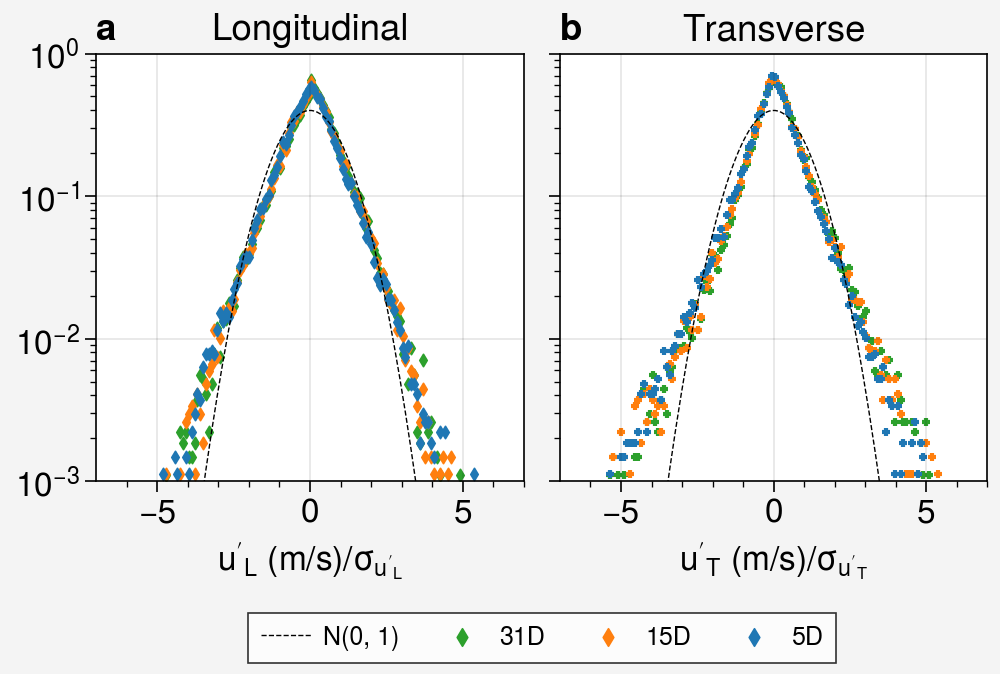

In [45]:
fig, axs = pplt.subplots(ncols=2, width="5in", sharex=False)
normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, symb, var in zip(axs, ['d', '+'], ['U_along', 'U_fluctuating']):
    for tau, c in zip(['31D', '15D', '5D'], ['tab:green', 'tab:orange', 'tab:blue']):
        u = results_anomalies[tau][var]
        ustd = results_anomalies[tau][var].std()
        print(tau, var, np.round(ustd*100, 3), 'cm/s')   
        pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        if 'along' in var:
            label = tau
            label_pdf = 'N(0, 1)'
        else:
            label = ''
            label_pdf = ''
        ax.scatter(x_center,
                   pdf, marker=symb,
                   color=c,  label=label, ms=10) 
     
    ax.plot(x_center, normal_dist(x_center), marker='', lw=0.5, color='k', ls='--', label=label_pdf)
    
axs[0].format(title='Longitudinal', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$')
axs[1].format(title='Transverse', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$')
# axs[0].legend(loc='ul', ncols=1)
fig.legend(loc='b', ncols=4, ms=20)
axs.format(yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
           yformatter='log', suptitle='', fontsize=12, abc=True)
fig.save('../figures/fig03_velocity_distribution_tau.pdf', dpi=300)

I separated the fluctuating velocity components by sea ice concentration. I need to revisit the sea ice concentration data, since I think I might be dropping data that has too low of SIC in the flagging process. Likely, the average velocities are not defined in regions with low sea ice concentration, so they are getting dropped at that point. There are a small number of outliers at low edge distances. I see more negative outliers than positive, which contradicts what I was seeing earlier. Some testable hypothesis:
- The distribution has an assymetric peak, and symmetric tails, which could suggest a slight direction bias between the tracked floes and the NSIDC ice motion vectors
- Large fluctuating velocities are less common as you go further from the ice edge, however, the bulk of the observations are within 250 km of the ice edge, so there are few floes available to test this hypothesis more deeply
- Negative outliers for high sea ice concentrations are nearly all in May and April, while the large outliers for moderate SIC are in June and July
- Could report the kurtosis of the distribution

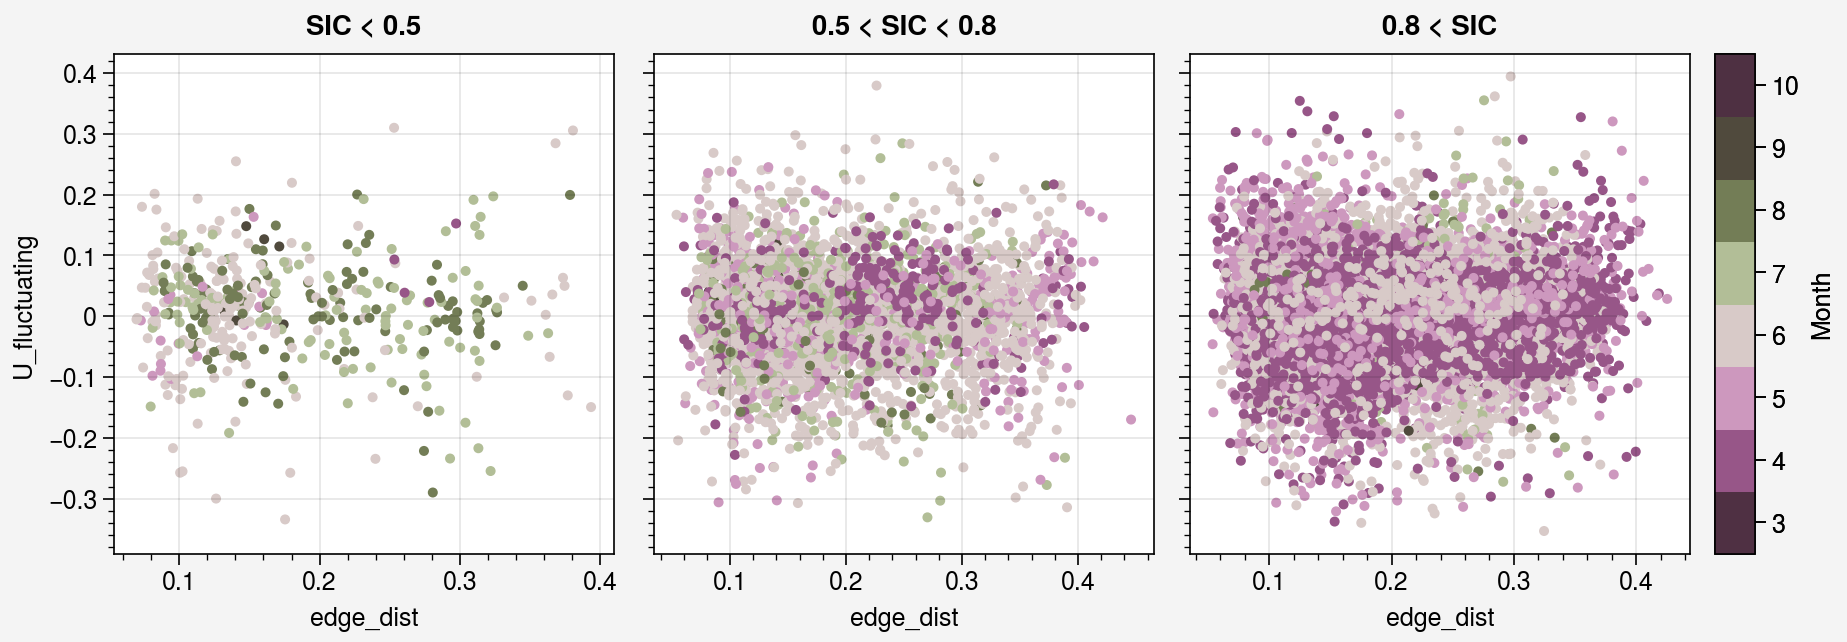

In [46]:
df = results_anomalies['5D']
fig, ax = pplt.subplots(ncols=3, sharex=False)
sic_idx = df.sea_ice_concentration < 0.5
c = ax[0].scatter(df.loc[sic_idx, 'edge_dist']/1e3, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.5
sic_idx = sic_idx & (df.sea_ice_concentration < 0.8)
ax[1].scatter(df.loc[sic_idx, 'edge_dist']/1e3, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.8
ax[2].scatter(df.loc[sic_idx, 'edge_dist']/1e3, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
fig.colorbar(c, loc='r', label='Month')
ax.format(toplabels=['SIC < 0.5', '0.5 < SIC < 0.8', '0.8 < SIC'])

There's likely an issue with where we have ice floe velocity measurements at a broad range of SIC but that we don't have NSIDC ice motion vectors for all those sites.


In [38]:
df = df.copy()
edge_bins = np.arange(0, 800, 25)
df['edge_bin'] = np.digitize(df.edge_dist, bins=edge_bins)
df_stdev = pd.concat({'sigma_ut': df[['edge_bin', 'U_fluctuating']].groupby('edge_bin').std(),
                      'sigma_ul': df[['edge_bin', 'U_along']].groupby('edge_bin').std(),
              'n': df[['edge_bin', 'U_fluctuating']].groupby('edge_bin').count(),
             'd': df[['edge_bin', 'edge_dist']].groupby('edge_bin').mean()}, axis=1)
df_stdev.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'd'])

length_bins = np.arange(0, 50, 2)
df['length_scale'] = df['floe_size']**0.5
df['length_bin'] = np.digitize(df.length_scale, bins=length_bins)
df_stdev_fsd = pd.concat({'sigma_ut': df[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df[['length_bin', 'U_along']].groupby('length_bin').std(),
              'n': df[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_stdev_fsd.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'L'])

31D U_along 7.992 cm/s
31D U_fluctuating 6.278 cm/s


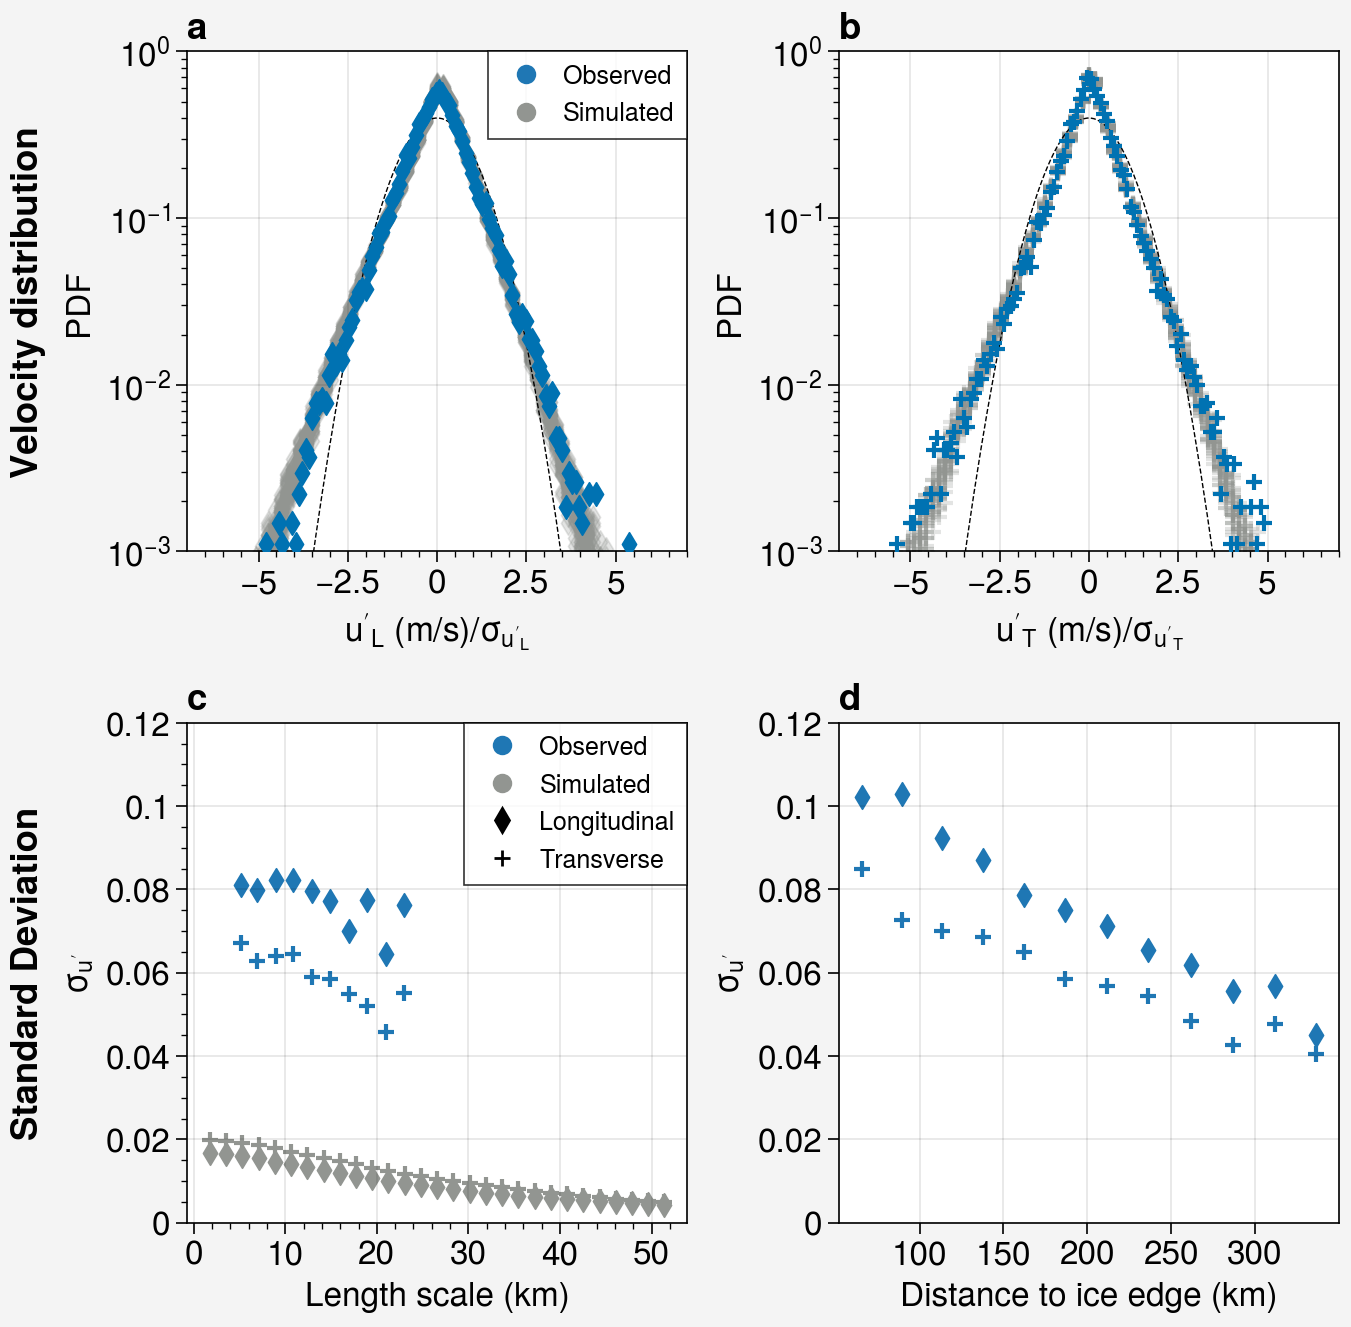

In [50]:
df = results_anomalies['5D'].copy()
length_bins = np.arange(0, 50, 2)
df['length_scale'] = df['floe_size']**0.5
df['length_bin'] = np.digitize(df.length_scale, bins=length_bins)
df_stdev_fsd = pd.concat({'sigma_ut': df[['length_bin', 'U_fluctuating']].groupby('length_bin').std(),
                      'sigma_ul': df[['length_bin', 'U_along']].groupby('length_bin').std(),
              'n': df[['length_bin', 'U_fluctuating']].groupby('length_bin').count(),
             'L': df[['length_bin', 'length_scale']].groupby('length_bin').mean()}, axis=1)
df_stdev_fsd.columns = pd.Index(['sigma_ut', 'sigma_ul', 'n', 'L'])

R = sim_std_dev['u_along (m/s)'].index
L = np.sqrt(np.pi)*R


fig, axs = pplt.subplots(ncols=2, nrows=2, share=False)

normal_dist = lambda x: 1/np.sqrt(2*np.pi)*np.exp(-1/2 * x**2)
for ax, symb, var in zip([axs[0], axs[1]], ['d', '+'], ['U_along', 'U_fluctuating']):
    u = df[var]
    ustd = df[var].std()
    print(tau, var, np.round(ustd*100, 3), 'cm/s')   
    pdf, x_bins = np.histogram(u/ustd, bins=np.linspace(-7, 7, 151), density=True)
    x_center = 1/2*(x_bins[1:] + x_bins[:-1])
    if 'along' in var:
        label_pdf = 'N(0, 1)'
    else:
        label_pdf = ''

    ax.scatter(x_center, pdf, marker=symb, label='', zorder=5) 
    ax.plot(x_center, normal_dist(x_center), marker='',
            lw=0.5, color='k', ls='--', label=label_pdf, zorder=1)
    
# The normalization in np.histogram is not the same as the normalization in
# Minki's matlab routine, to bring them to the same convention, we need to divide by
# the bin spacing. 
dx = np.diff(sim_uacross.index)[0]
   
for col in sim_ualong.columns:
    axs[0].scatter(sim_ualong.index, sim_ualong.loc[:, col]/dx, color='gray',
                m='d', alpha=0.25, label='', zorder=0)
    axs[1].scatter(sim_uacross.index, sim_uacross.loc[:, col]/dx, color='gray',
                alpha=0.25, m='+',  label='', zorder=0)
    
axs[0].format(title='', xlabel='$u\'_L$ (m/s)/$\sigma_{u\'_L}$',
              yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')
axs[1].format(title='', xlabel='$u\'_T$ (m/s)/$\sigma_{u\'_T}$',
              yscale='log', ylim=(1e-3, 1), xlim=(-7, 7),
              yformatter='log', ylabel='PDF')

# axs[0].legend(loc='ul', ncols=1)
# fig.legend(loc='b', ncols=4, ms=6)

# fig.save('../figures/fig_01v2_alongtrack_crosstrack_velocity_anomaly.pdf', dpi=300)

idx = df_stdev_fsd.n > 300
ax = axs[2]
ax.scatter(df_stdev_fsd.loc[idx, 'L'].values,
        df_stdev_fsd.loc[idx, 'sigma_ul'].values,
        marker='d', label='', color='tab:blue')
ax.scatter(df_stdev_fsd.loc[idx, 'L'].values,
        df_stdev_fsd.loc[idx, 'sigma_ut'].values,
        marker='+', label='', color='tab:blue')
ax.scatter(L, sim_std_dev['u_along (m/s)'],
           marker='d', label='', color='gray')
ax.scatter(L, sim_std_dev['u_across (m/s)'],
           marker='+', label='', color='gray')



idx = df_stdev.n > 300
axs[3].scatter(df_stdev.loc[idx, 'd'].values,
               df_stdev.loc[idx, 'sigma_ul'].values, marker='d', color='tab:blue')
axs[3].scatter(df_stdev.loc[idx, 'd'].values,
               df_stdev.loc[idx, 'sigma_ut'].values, marker='+', color='tab:blue')
axs[3].format(ylim=(0, 0.12), ytickminor=False, xtickminor=False,
         ylabel='$\sigma_{u\'}$', xlabel='Distance to ice edge (km)', fontsize=12)

l = ['Observed', 'Simulated', 'Longitudinal', 'Transverse']
h = [ax.plot([],[], marker=m, color=c, lw=0) for m, c in zip(['o', 'o', 'd', '+'],
                                                       ['tab:blue', 'gray', 'k', 'k'])]

axs[0].legend(h[0:2], l[0:2], ncols=1)

axs[2].format(ylim=(0, 0.12))
axs[3].format(ylim=(0, 0.12))
ax.format(xlabel='Length scale (km)', ylabel='$\sigma_{u\'}$', title='')
ax.legend(h, l, loc='ur', ncols=1)
fig.format(abc=True, fontsize=12, leftlabels=['Velocity distribution', 'Standard Deviation'])
fig.save('../figures/fig04_velocity_obs_sim.pdf', dpi=300)

In [51]:
print('Unfiltered', df_ift.shape[0])
print('Filtered', df_ift.loc[df_ift.qc_flag==0].shape[0])
print('With SIC', df_ift.loc[(df_ift.qc_flag==0) & df_ift.sea_ice_concentration.notnull()].shape[0])
print('With NSIDC Ice Motion', df_ift.loc[(df_ift.qc_flag==0) & df_ift.u_nsidc.notnull()].shape[0])
print('With NSIDC Ice Motion & SIC', df_ift.loc[(df_ift.qc_flag==0) & (df_ift.u_nsidc.notnull() & df_ift.sea_ice_concentration.notnull()) ].shape[0])

Unfiltered 64435


AttributeError: 'DataFrame' object has no attribute 'qc_flag'

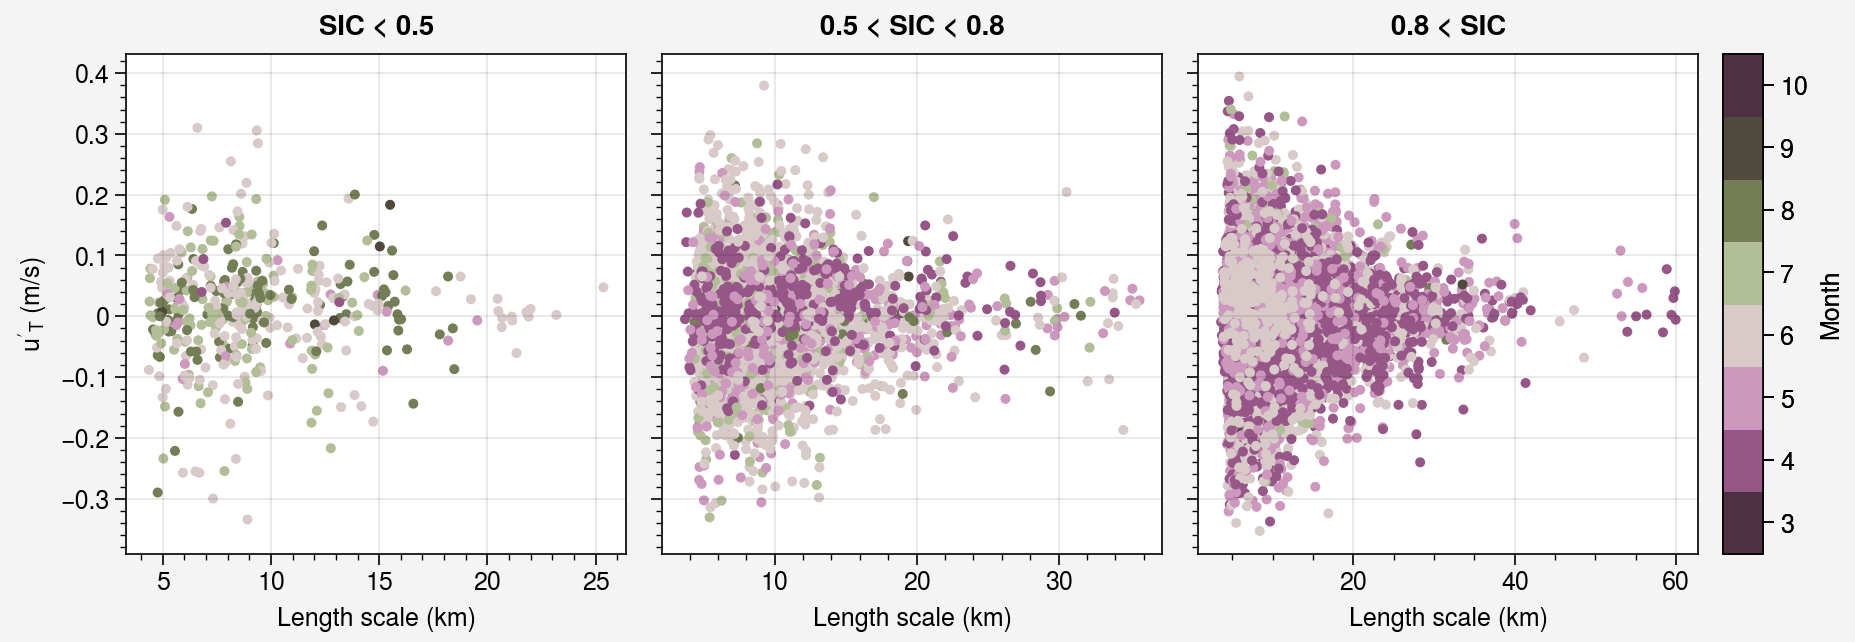

In [524]:
df = results_anomalies['5D']
fig, ax = pplt.subplots(ncols=3, sharex=False)
sic_idx = df.sea_ice_concentration < 0.5
c = ax[0].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.5
sic_idx = sic_idx & (df.sea_ice_concentration < 0.8)
ax[1].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
sic_idx = df.sea_ice_concentration > 0.8
ax[2].scatter(df.loc[sic_idx, 'floe_size']**0.5, df.loc[sic_idx, 'U_fluctuating'], m='.',
              c=df.loc[sic_idx, 'datetime'].dt.month, cmap='bamO', vmin=2.5, vmax=10.5, N=8)
fig.colorbar(c, loc='r', label='Month')
ax.format(toplabels=['SIC < 0.5', '0.5 < SIC < 0.8', '0.8 < SIC'])
ax.format(ylabel='$u\'_T$ (m/s)', xlabel='Length scale (km)')

From the scatterplots, we can see a possible month dependence, and a pretty clear length scale dependence. The length scale dependence is harder to see in the low sea ice concentration due to the smaller number of observations. It appears to me (I aim to quantify this with percentiles) that there is a change in the scale of the distribution with increasing floe length scale. There may be differences between months in the number of floes at each length scale that may make it difficult to compare, so a bootstrap approach would likely be useful here.

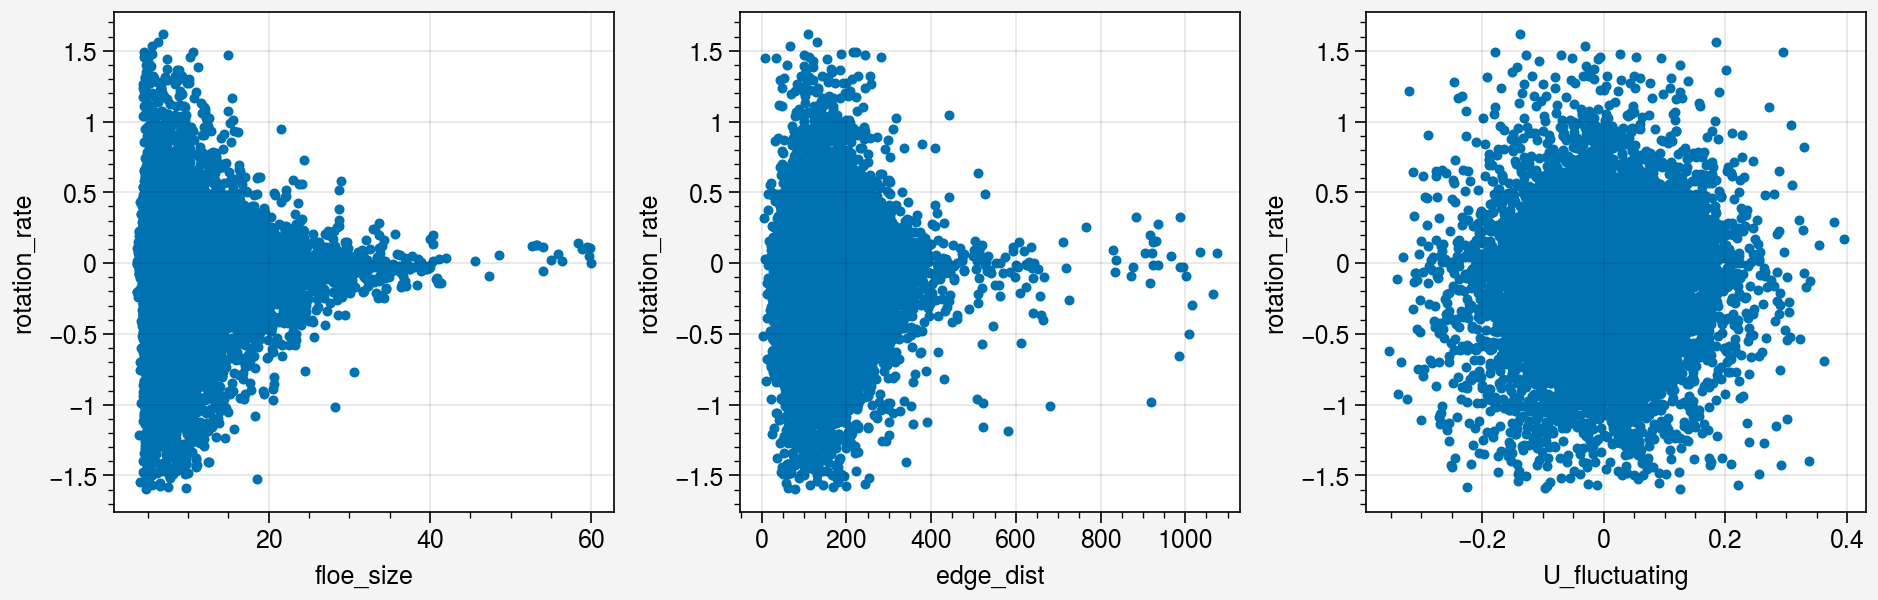

In [525]:
fig, ax = pplt.subplots(ncols=3, share=False)
ax[0].scatter(results_anomalies['5D']['floe_size']**0.5, results_anomalies['5D']['rotation_rate'], 
           marker='.')
ax[1].scatter(results_anomalies['5D']['edge_dist']/1e3, results_anomalies['5D']['rotation_rate'], marker='.')
ax[2].scatter(results_anomalies['5D']['U_fluctuating'], results_anomalies['5D']['rotation_rate'], marker='.')

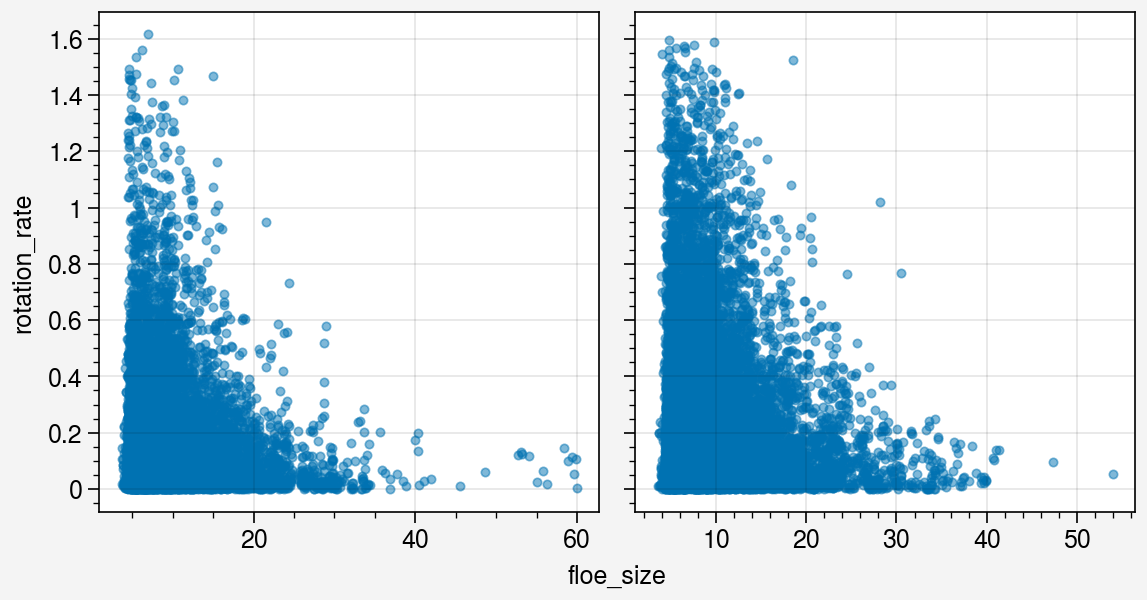

In [526]:
fig, ax = pplt.subplots(ncols=2, share=True)
anticyclonic = results_anomalies['5D']['rotation_rate'].where(results_anomalies['5D']['rotation_rate'] > 0)
cyclonic = results_anomalies['5D']['rotation_rate'].where(results_anomalies['5D']['rotation_rate'] < 0)
ax[0].scatter(results_anomalies['5D']['floe_size']**0.5, anticyclonic, 
           marker='.', alpha=0.5)
ax[1].scatter(results_anomalies['5D']['floe_size']**0.5, -cyclonic, 
           marker='.', alpha=0.5)


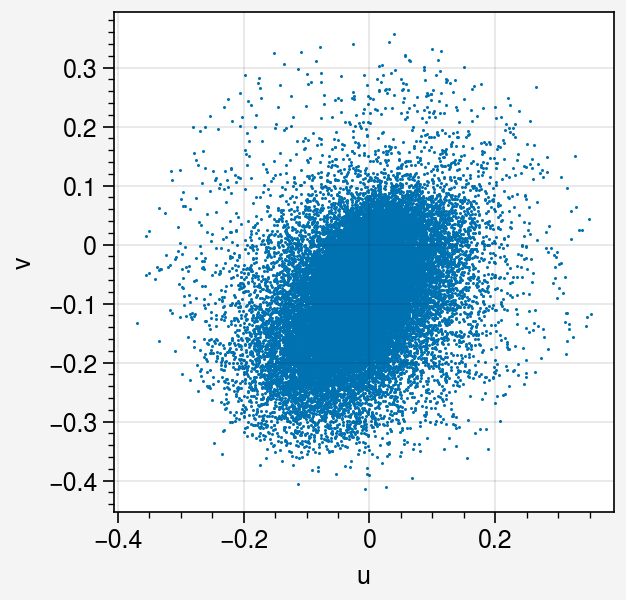

In [527]:
large_fluctuations = df_filtered.loc[np.abs(df_filtered.U_fluctuating) > 0.5]
fig, ax = pplt.subplots()
# ax.scatter(df_ift.u, df_ift.v, marker='.', ms=1)
ax.scatter(df_filtered.u, df_filtered.v, m='.', ms=1)
ax.scatter(large_fluctuations.u, large_fluctuations.v)

If we separate out the effects of edge distance, do we still see a rotation rate effect in the floe sizes?

The goal is to quantify the joint relationship between rotation rate, edge distance, and floe size, as the three appear to be mutually correlated. However, it is not clear how we should do this. I suspect that the thing we want to do is to quantify the spread of the distribution. The circular standard deviation is probably the right way to go but there are some questions I have about the dependence on the choice of high and low thresholds. 

In [452]:
df_ift['edge_dist'].max()


2109901.0

In [528]:
from scipy.stats import circmean, circstd


Using the regular standard deviation, there appears to be an effect with the length scale within edge distance groups, but oddly, I don't see the effect when using the circular standard deviation.
When we bin the rotation rate observations by the distance to the ice edge, we find that the signal is noisy, but that there does appear to be some kind of effect. I'm not sure what the appropriate statistic is here. While we still need to figure out the appropriate method to test statistical significance. 

The results are non-intuitive and depend on the choice of high and low angles. I need to think carefully about this so that we aren't mislead. However, it is extremely clear in the data that there is a dependency of some sort.

In [510]:
# I think there's an error in the edge distance calculation, since there are data points at 70 latitude registering as
# over 400 km from the ice edge. Let's take a look at those again.

In [534]:
df_filtered.loc[df_filtered.edge_dist > 400e3].sea_ice_concentration

2003    0.96
2003    1.00
2003    0.89
2003    0.92
2003    0.89
        ... 
2020    0.70
2020    0.78
2020    0.71
2020    0.76
2020    0.52
Name: sea_ice_concentration, Length: 322, dtype: float64

## Considering the effect of the wind

Can the velocity fluctuatings be explained by the wind? We consider the effect of the wind based on the ERA5 daily average wind reanalysis (itself an estimate). We employ a linear free drift model $$u'_{ice} = \alpha \exp^{-i\theta} U_{wind} + \overline{U}_{ice}$$. To find the best fit for the parameters $\alpha$ and $\theta$, we take a random sample of $n=1000$ observations, calculate the empirical drift speed ratio $\alpha$ and turning angle $\theta$ relative to the velocity perturbation $u'$, and calculate the expected value of $\alpha$ and $\theta$. (For $\theta$, the expected value uses a circular mean).

In [31]:
import metpy.calc as mcalc
from metpy.units import units

In [188]:
df_filtered.reset_index(inplace=True, drop=True)
up = df_filtered['u'] - df_filtered['u5D_nsidc'] + 1j*(df_filtered['v'] - df_filtered['v5D_nsidc'])

# up = df_filtered['u'] + 1j*df_filtered['v']
uw = df_filtered['u_wind'] + 1j*df_filtered['v_wind']

In [189]:
wind_bearing = mcalc.wind_direction(df_filtered['u_wind'].values * units('m/s'),
                                    df_filtered['v_wind'].values * units('m/s'), convention='to')
ice_bearing = mcalc.wind_direction(np.real(up) * units('m/s'),
                                   np.imag(up) * units('m/s'), convention='to')
delta = np.deg2rad(ice_bearing.magnitude) - np.deg2rad(wind_bearing.magnitude)
turning_angle = pd.Series(np.rad2deg(np.arctan2(np.sin(delta), np.cos(delta))),
                          index=df_filtered.index)

drift_speed_ratio = np.abs(up) / df_filtered['wind_speed']

In [190]:
data_df = pd.DataFrame({'theta': turning_angle, 
                       'alpha': drift_speed_ratio})
data_df.dropna(inplace=True)


In [284]:
theta = np.deg2rad(25)
up_est = 0.015*np.exp(-1j*theta)*uw

In [306]:
test_df = pd.DataFrame({
    'latitude': df_filtered['latitude'],
    'longitude': df_filtered['longitude'],
    'floe_size': df_filtered['area'],
    'edge_dist': df_filtered['edge_dist'],    
    'sea_ice_concentration': df_filtered['sea_ice_concentration'],
    'uL_ice': df_filtered['U_along'],
    'uT_ice': df_filtered['U_fluctuating'],
    'u_est': np.real(up_est),
    'v_est': np.imag(up_est),
    'u_mean': df_filtered['u5D_nsidc'],
    'v_mean': df_filtered['v5D_nsidc']})
test_df = compute_along_across_components(test_df, uvar='u_est', vvar='v_est')

In [307]:
test_df.rename({'U_fluctuating': 'uT_ice_est',
                'U_along': 'uL_ice_est'}, axis=1, inplace=True)

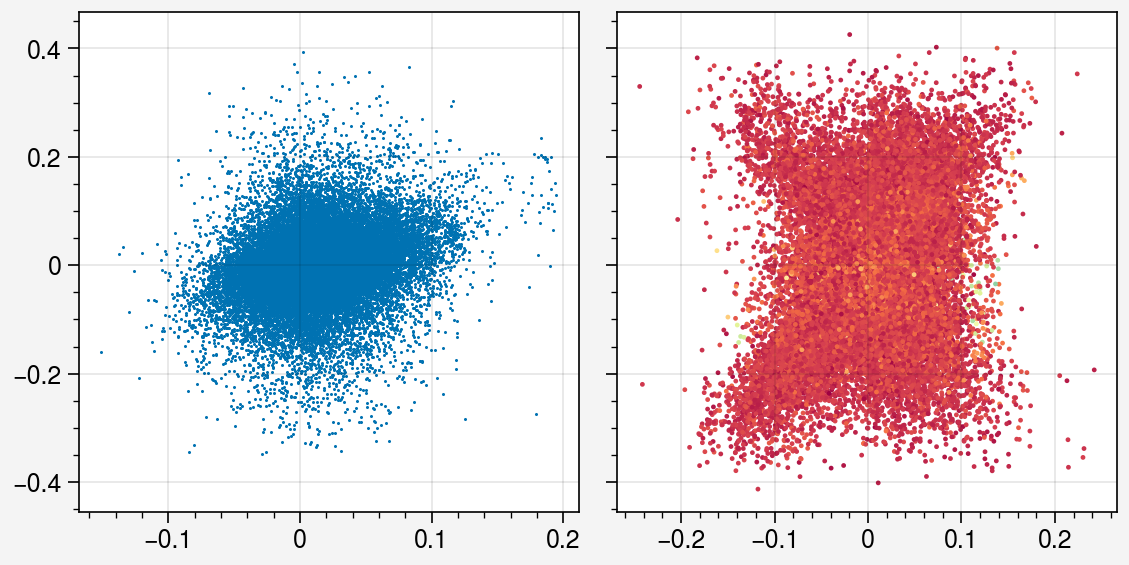

In [308]:
fig, ax = pplt.subplots(ncols=2)
ax[0].scatter(test_df['uT_ice_est'].values, test_df['uT_ice'].values, marker='.', ms=1)
ax[1].scatter(test_df['uL_ice_est'].values, test_df['uL_ice'].values,
              marker='.', ms=5, c=test_df['edge_dist'], cmap='spectral')

In [317]:
test_df['err'] = np.sqrt((test_df['uL_ice_est'] - test_df['uL_ice'])**2 + (test_df['uT_ice_est'] - test_df['uT_ice'])**2)

In [319]:
extremes = test_df.loc[test_df.err > 0.3]

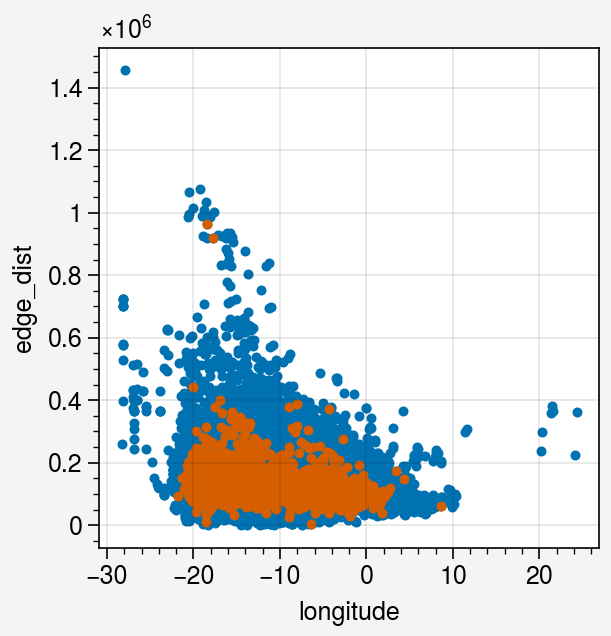

In [322]:
fig, ax = pplt.subplots()
ax.scatter(test_df.longitude, test_df.edge_dist, marker='.')
ax.scatter(extremes.longitude, extremes.edge_dist, marker='.')

In [191]:
%time
n = 1000
bs_n = 10000
# Resampling:
alpha = []
theta = []
for idx in range(bs_n):
    data_samp = data_df.sample(n, replace=True)
    theta.append(np.rad2deg(circmean(np.deg2rad(data_samp['theta']),
                               high=np.pi, low=-np.pi)))
    alpha.append(data_samp['alpha'].median())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


(array([   4.,   33.,  297., 1147., 2517., 3035., 2059.,  738.,  144.,
          26.]),
 array([34.09980967, 37.14513454, 40.19045942, 43.23578429, 46.28110917,
        49.32643404, 52.37175892, 55.41708379, 58.46240867, 61.50773354,
        64.55305842]),
 <BarContainer object of 10 artists>)

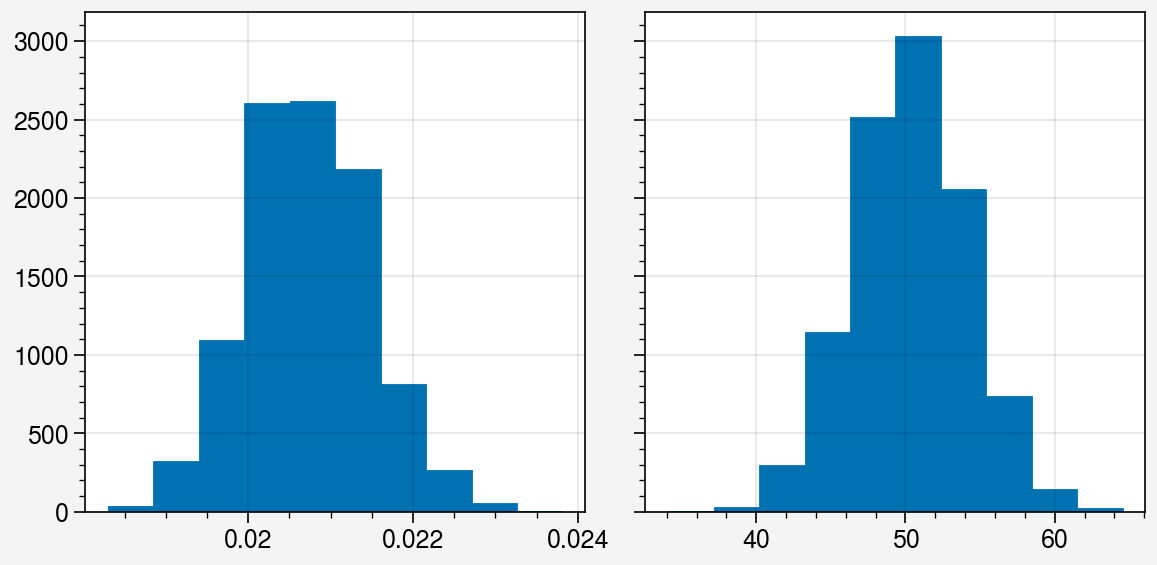

In [192]:
fig, ax = pplt.subplots(ncols=2)
ax[0].hist(alpha)
ax[1].hist(theta)

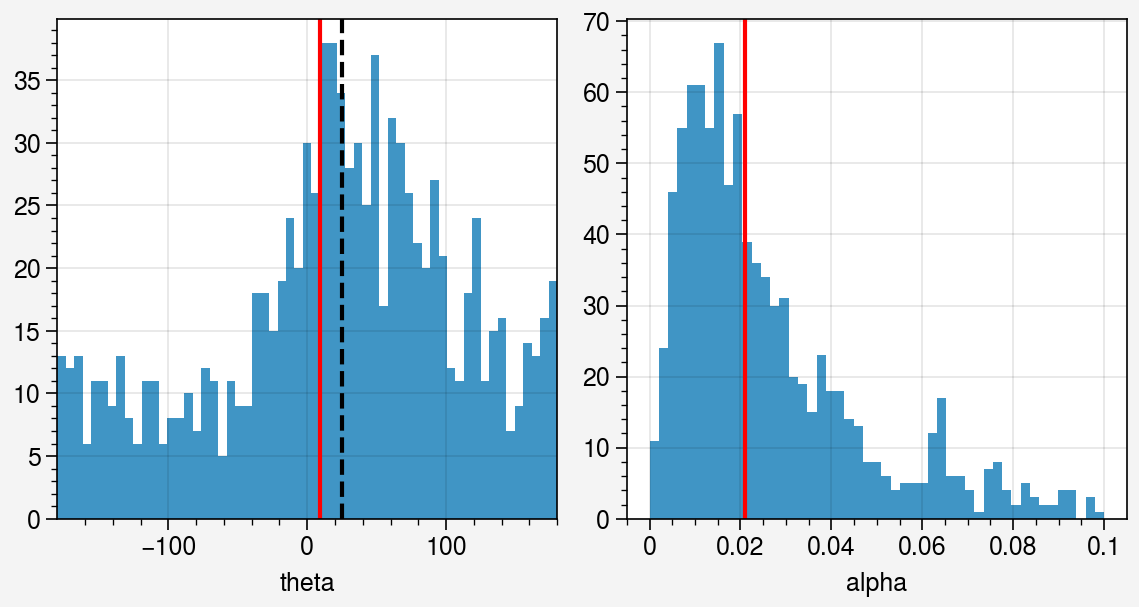

In [194]:
from scipy.stats import circmean
fig, axs = pplt.subplots(ncols=2, share=False)
pdf = axs[0].hist(data_samp['theta'], bins=np.linspace(-180, 180, 60), alpha=0.75)
axs[0].axvline(pdf[1][pdf[0].argmax()], color='r')
axs[0].axvline(25, color='k', ls='--')
axs[0].format(xlim=(-180, 180))
_ = axs[1].hist(data_samp['alpha'], bins=np.linspace(0, 0.1, 50), alpha=0.75)
axs[1].axvline(np.median(data_samp['alpha']), color='r')

For each random sample, we find the value of theta that minimizes the square error $\hat U - u_{ice}$.

In [173]:
alpha = 0.01
theta = np.linspace(10, 70, 100)
mse = []
for th in theta:
    u_est= alpha*np.exp(-1j*np.deg2rad(th))*uw
    mse.append(np.mean(np.abs(u_est - up)**2))

In [186]:
%%time
n = 1000
bs_n = 1000
alpha = 0.01
theta = np.linspace(10, 70, 100)
results_mse = []
for idx in range(bs_n):
    mse = []
    idx = df_filtered.sample(n).index
    for th in theta:
        u_est= alpha*np.exp(-1j*np.deg2rad(th))*uw[idx]
        mse.append(np.mean(np.abs(u_est - up[idx])**2))
    theta_min = theta[np.array(mse).argmin()]
    results_mse.append(theta_min)

CPU times: user 2min 35s, sys: 1.5 s, total: 2min 36s
Wall time: 2min 49s


(array([ 19.,  47., 148., 169., 195., 241.,  94.,  67.,  13.,   7.]),
 array([39.09090909, 40.54545455, 42.        , 43.45454545, 44.90909091,
        46.36363636, 47.81818182, 49.27272727, 50.72727273, 52.18181818,
        53.63636364]),
 <BarContainer object of 10 artists>)

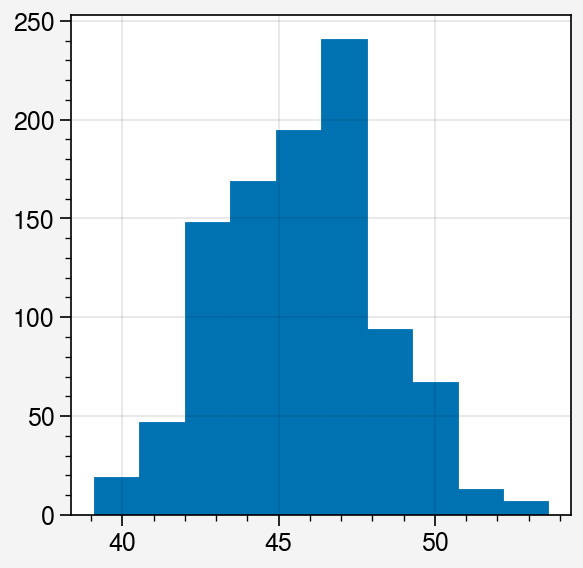

In [187]:
fig, ax = pplt.subplots()
ax.hist(results_mse)

Error is actually minimized for a turning angle of 46 degrees. This doesn't seem right. Are we getting the right wind speeds here?

In [206]:
df_long = df_filtered.groupby('floe_id').filter(lambda x: len(x) > 6)
floes_long = {f: g for f, g in df_long.groupby('floe_id')}


Double check the velocity components - do they actually make sense? Are my velocity directions consistent? Why is it that 45 degrees minimizes error, but the mode is at about 25?

What direction should the arrows be pointing compared to spatial locations?

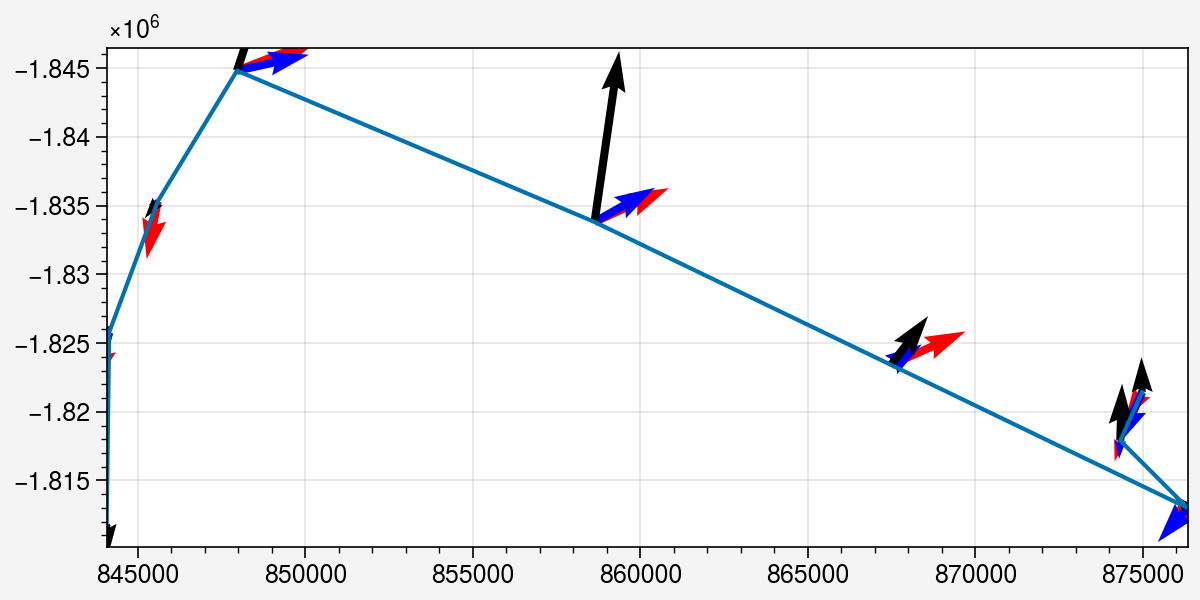

In [283]:
fig, ax = pplt.subplots(width=6, height=3)
group = floes_long['2003_00452']
ax.plot(group.x_stere.values, group.y_stere.values)
ax.quiver(group.x_stere.values, group.y_stere.values, group.u.values, group.v.values, color='r')
ax.quiver(group.x_stere.values, group.y_stere.values, group.u_nsidc.values, group.v_nsidc.values, color='b')
ax.quiver(group.x_stere.values, group.y_stere.values, group.u_wind.values, group.v_wind.values)